In [131]:
# Análisis numérico y datos
import numpy as np
import pandas as pd
from scipy import stats
import scipy.optimize as opt

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.style as style

# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score, roc_auc_score, roc_curve
)

import warnings

# Configuraciones
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [132]:
df = pd.read_csv("../data/partidos_final.csv")

In [133]:
df['Date'] = pd.to_datetime(df['Date'])

In [134]:
df.columns

Index(['index', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'Player_1', 'Player_2', 'Winner', 'Rank_1', 'Rank_2',
       'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Score', 'Age_Player1',
       'Age_Player2', 'Rank_Diff', 'Target', 'Series_Ordinal', 'Round_Ordinal',
       'Surface_Carpet', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard',
       'Court_Indoor', 'Best_of_5', 'Age_Diff', 'P1_Wins_Last_5',
       'P2_Wins_Last_5', 'Wins_Last_5_Diff', 'H2H_Advantage',
       'P1_Recent_Win_Pct', 'P2_Recent_Win_Pct', 'Recent_Form_10_Diff',
       'P1_Elo_Before', 'P2_Elo_Before', 'Elo_Diff', 'P1_Elo_Surface',
       'P2_Elo_Surface', 'Elo_Surface_Diff', 'Title_Win', 'P1_Title_Won',
       'P2_Title_Won', 'P1_Tournament_Titles_Dynamic',
       'P2_Tournament_Titles_Dynamic', 'Tournament_Titles_Diff_Dynamic',
       'Grand_Title_Win', 'P1_Grand_Title_Won', 'P2_Grand_Title_Won',
       'P1_Grand_Titles_Dynamic', 'P2_Grand_Titles_Dynamic',
       'Grand_Titles_Diff_

In [75]:
# --- 5. DEFINICIÓN FINAL DE MATRIZ DE FEATURES Y ENTRENAMIENTO ---

# Matriz de Features (X)
FEATURE_COLUMNS = [
    'Rank_Diff', 'Tournament_Titles_Diff', 'Wins_Last_5_Diff', 'Age_Diff',
    'Series_Ordinal', 'Round_Ordinal',
    'Court_Indoor', 'Best_of_5', 'Surface_Hard', 'Surface_Clay', 
    'Surface_Grass', 'Surface_Carpet',
    'H2H_Advantage', 'Recent_Form_10_Diff',
    'Elo_Diff', 'Elo_Surface_Diff', 'Grand_Titles_Diff'
]

X = df[FEATURE_COLUMNS]
y = df['Target']

# **MODELO 1**

In [76]:
# División CRONOLÓGICA (Entrenar en el pasado, probar en el futuro)
X_train = df[df['Date'].dt.year < 2022][FEATURE_COLUMNS]
y_train = df[df['Date'].dt.year < 2022]['Target']

X_test = df[df['Date'].dt.year >= 2022][FEATURE_COLUMNS]
y_test = df[df['Date'].dt.year >= 2022]['Target']

In [77]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53475, 17)
(53475,)
(8854, 17)
(8854,)


In [78]:
# Entrenar el Random Forest
model1 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=10)
model1.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
from sklearn.metrics import accuracy_score
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Y_pred_train = model1.predict(X_train)
accuracy_train = accuracy_score(y_train, Y_pred_train)

print("\n--- RESUMEN FINAL ---")
print(f"Features predictivas (X) usadas: {len(FEATURE_COLUMNS)}")
print(f"Tamaño del set de entrenamiento (antes de 2022): {len(X_train)} partidos")
print(f"Precisión en el set de ENTRENAMIENTO (Train): {accuracy_train:.4f}")
print(f"Precisión del Random Forest en partidos de 2022 (test): {accuracy:.4f}")


--- RESUMEN FINAL ---
Features predictivas (X) usadas: 17
Tamaño del set de entrenamiento (antes de 2022): 53475 partidos
Precisión en el set de ENTRENAMIENTO (Train): 0.7113
Precisión del Random Forest en partidos de 2022 (test): 0.6541


In [80]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. Obtener las predicciones discretas y las probabilidades
y_proba = model1.predict_proba(X_test)[:, 1] # Probabilidad de que P1 gane (Clase 1)

# --- MATRIZ DE CONFUSIÓN ---
print("\n--- MATRIZ DE CONFUSIÓN (TEST) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- CLASSIFICATION REPORT (Precision, Recall, F1) ---
print("\n--- CLASSIFICATION REPORT (TEST) ---")
# La clase '1' es P1 Gana, la clase '0' es P2 Gana (P1 Pierde)
print(classification_report(y_test, y_pred))

# --- ROC AUC SCORE ---
# Mide la habilidad del modelo para distinguir entre clases
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score (TEST): {roc_auc:.4f}")


--- MATRIZ DE CONFUSIÓN (TEST) ---
[[2924 1506]
 [1557 2867]]

--- CLASSIFICATION REPORT (TEST) ---
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      4430
           1       0.66      0.65      0.65      4424

    accuracy                           0.65      8854
   macro avg       0.65      0.65      0.65      8854
weighted avg       0.65      0.65      0.65      8854


ROC AUC Score (TEST): 0.7216


In [81]:
# Datos proporcionados por el usuario
feature_importances_ = np.array(model1.feature_importances_)

# 1. Crear el DataFrame
# Se utiliza un diccionario para mapear las listas a las columnas
df_importances = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': feature_importances_
})

# 2. Ordenar el DataFrame por la columna 'Importance' de forma descendente (de mayor a menor)
df_sorted = df_importances.sort_values(by='Importance', ascending=False)

# 3. Mostrar el DataFrame ordenado
print("DataFrame de Importancia de Características (Ordenado):")
df_sorted

DataFrame de Importancia de Características (Ordenado):


,Feature,Importance
14,Elo_Diff,0.262879
15,Elo_Surface_Diff,0.205957
0,Rank_Diff,0.164054
1,Tournament_Titles_Diff,0.151107
13,Recent_Form_10_Diff,0.055060
2,Wins_Last_5_Diff,0.040014
3,Age_Diff,0.032573
16,Grand_Titles_Diff,0.031134
12,H2H_Advantage,0.015262
5,Round_Ordinal,0.011706


In [82]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelo1 = 'random_forest_modelo1.joblib'

# Guardar el modelo
joblib.dump(model1, modelo1)

print(f"Modelo guardado exitosamente como: {modelo1}")

Modelo guardado exitosamente como: random_forest_modelo1.joblib


# **MODELO 2**

Modificación de datos de entrenamiento y test

In [83]:
# División CRONOLÓGICA (Entrenar en el pasado, probar en el futuro)
X_train = df[df['Date'].dt.year < 2016][FEATURE_COLUMNS]
y_train = df[df['Date'].dt.year < 2016]['Target']

X_test = df[df['Date'].dt.year >= 2016][FEATURE_COLUMNS]
y_test = df[df['Date'].dt.year >= 2016]['Target']

In [84]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40250, 17)
(40250,)
(22079, 17)
(22079,)


In [85]:
# Entrenar el Random Forest
model2 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=10)
model2.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [86]:
from sklearn.metrics import accuracy_score
y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Y_pred_train = model2.predict(X_train)
accuracy_train = accuracy_score(y_train, Y_pred_train)

print("\n--- RESUMEN FINAL ---")
print(f"Features predictivas (X) usadas: {len(FEATURE_COLUMNS)}")
print(f"Tamaño del set de entrenamiento: {len(X_train)} partidos")
print(f"Precisión en el set de ENTRENAMIENTO (Train): {accuracy_train:.4f}")
print(f"Precisión del Random Forest (test): {accuracy:.4f}")


--- RESUMEN FINAL ---
Features predictivas (X) usadas: 17
Tamaño del set de entrenamiento: 40250 partidos
Precisión en el set de ENTRENAMIENTO (Train): 0.7217
Precisión del Random Forest (test): 0.6572


In [87]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. Obtener las predicciones discretas y las probabilidades
y_proba = model2.predict_proba(X_test)[:, 1] # Probabilidad de que P1 gane (Clase 1)

# --- MATRIZ DE CONFUSIÓN ---
print("\n--- MATRIZ DE CONFUSIÓN (TEST) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- CLASSIFICATION REPORT (Precision, Recall, F1) ---
print("\n--- CLASSIFICATION REPORT (TEST) ---")
# La clase '1' es P1 Gana, la clase '0' es P2 Gana (P1 Pierde)
print(classification_report(y_test, y_pred))

# --- ROC AUC SCORE ---
# Mide la habilidad del modelo para distinguir entre clases
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score (TEST): {roc_auc:.4f}")


--- MATRIZ DE CONFUSIÓN (TEST) ---
[[7320 3717]
 [3851 7191]]

--- CLASSIFICATION REPORT (TEST) ---
              precision    recall  f1-score   support

           0       0.66      0.66      0.66     11037
           1       0.66      0.65      0.66     11042

    accuracy                           0.66     22079
   macro avg       0.66      0.66      0.66     22079
weighted avg       0.66      0.66      0.66     22079


ROC AUC Score (TEST): 0.7232


El ROC AUC de 0.7074 indica que el modelo tiene dificultad para separar bien las probabilidades de victoria

In [88]:
# Datos proporcionados por el usuario
feature_importances_ = np.array(model2.feature_importances_)

# 1. Crear el DataFrame
# Se utiliza un diccionario para mapear las listas a las columnas
df_importances = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': feature_importances_
})

# 2. Ordenar el DataFrame por la columna 'Importance' de forma descendente (de mayor a menor)
df_sorted = df_importances.sort_values(by='Importance', ascending=False)

# 3. Mostrar el DataFrame ordenado
print("DataFrame de Importancia de Características (Ordenado):")
df_sorted

DataFrame de Importancia de Características (Ordenado):


,Feature,Importance
14,Elo_Diff,0.257793
15,Elo_Surface_Diff,0.202009
0,Rank_Diff,0.168651
1,Tournament_Titles_Diff,0.148214
13,Recent_Form_10_Diff,0.055918
2,Wins_Last_5_Diff,0.042563
3,Age_Diff,0.033524
16,Grand_Titles_Diff,0.028490
12,H2H_Advantage,0.017196
5,Round_Ordinal,0.012977


In [89]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelo2 = 'random_forest_modelo2.joblib'

# Guardar el modelo
joblib.dump(model2, modelo2)

print(f"Modelo guardado exitosamente como: {modelo2}")

Modelo guardado exitosamente como: random_forest_modelo2.joblib


# **MODELO 3**

Fine-tunning y corrección de hiperparámetros con RandomizedSearchCV con TimeSeriesSplit.  

El ROC AUC de 0.7074 indica dificultades para separar bien las probabilidades de victoria.  
Para mover el AUC y la Precisión real por encima de 0.70, hay que mejorar la señal predictiva de los datos.  

scoring='roc_auc', -> Usa ROC AUC para la optimización  

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

param_grid = {
    'max_depth': [5, 6, 7, 8, 11, 15, 20, None],
    'n_estimators': [100, 300, 500],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 15]
}

# 2. Definir la validación cruzada para series temporales
# 5 ciclos de entrenamiento/validación cronológicos
tscv = TimeSeriesSplit(n_splits=5) 

# 3. Inicializar el modelo base (manteniendo parámetros fijos como class_weight='balanced')
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

# 4. Configurar RandomizedSearchCV
# n_iter=20: número de combinaciones a probar
# scoring='roc_auc':  usar ROC AUC sobre accuracy para optimizar la distinción de clases.
random_search = RandomizedSearchCV(
    estimator=rf_base, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring='roc_auc', # Usa ROC AUC para la optimización
    cv=tscv,           # ¡Usar TimeSeriesSplit!
    verbose=2, 
    n_jobs=-1,         # Usa todos los núcleos del procesador
    random_state=42
)

In [91]:
# 5. Ejecutar la búsqueda (usando tus X_train y Y_train)
random_search.fit(X_train, y_train) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [5, 6, ...], 'min_samples_leaf': [1, 5, ...], 'min_samples_split': [5, 10, ...], 'n_estimators': [100, 300, ...]}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [92]:
# 6. Obtener los mejores parámetros
best_estimator = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f" El mejor estimador fue: {best_estimator}")
print(f"Los mejores parámetros fueron: {best_params}")
print(f"El mejor score fue: {best_score}")

 El mejor estimador fue: RandomForestClassifier(class_weight='balanced', max_depth=11,
                       min_samples_leaf=15, min_samples_split=5,
                       n_estimators=300, random_state=42)
Los mejores parámetros fueron: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_depth': 11}
El mejor score fue: 0.7572913372093981


In [93]:
model3 = best_estimator

In [94]:
from sklearn.metrics import accuracy_score
y_pred = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Y_pred_train = model3.predict(X_train)
accuracy_train = accuracy_score(y_train, Y_pred_train)

print("\n--- RESUMEN FINAL ---")
print(f"Features predictivas (X) usadas: {len(FEATURE_COLUMNS)}")
print(f"Tamaño del set de entrenamiento: {len(X_train)} partidos")
print(f"Precisión en el set de ENTRENAMIENTO (Train): {accuracy_train:.4f}")
print(f"Precisión del Random Forest (test): {accuracy:.4f}")


--- RESUMEN FINAL ---
Features predictivas (X) usadas: 17
Tamaño del set de entrenamiento: 40250 partidos
Precisión en el set de ENTRENAMIENTO (Train): 0.7158
Precisión del Random Forest (test): 0.6577


In [95]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. Obtener las predicciones discretas y las probabilidades
y_proba = model3.predict_proba(X_test)[:, 1] # Probabilidad de que P1 gane (Clase 1)

# --- MATRIZ DE CONFUSIÓN ---
print("\n--- MATRIZ DE CONFUSIÓN (TEST) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- CLASSIFICATION REPORT (Precision, Recall, F1) ---
print("\n--- CLASSIFICATION REPORT (TEST) ---")
# La clase '1' es P1 Gana, la clase '0' es P2 Gana (P1 Pierde)
print(classification_report(y_test, y_pred))

# --- ROC AUC SCORE ---
# Mide la habilidad del modelo para distinguir entre clases
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score (TEST): {roc_auc:.4f}")


--- MATRIZ DE CONFUSIÓN (TEST) ---
[[7316 3721]
 [3837 7205]]

--- CLASSIFICATION REPORT (TEST) ---
              precision    recall  f1-score   support

           0       0.66      0.66      0.66     11037
           1       0.66      0.65      0.66     11042

    accuracy                           0.66     22079
   macro avg       0.66      0.66      0.66     22079
weighted avg       0.66      0.66      0.66     22079


ROC AUC Score (TEST): 0.7240


In [96]:
# Datos proporcionados por el usuario
feature_importances_ = np.array(model3.feature_importances_)

# 1. Crear el DataFrame
# Se utiliza un diccionario para mapear las listas a las columnas
df_importances = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': feature_importances_
})

# 2. Ordenar el DataFrame por la columna 'Importance' de forma descendente (de mayor a menor)
df_sorted = df_importances.sort_values(by='Importance', ascending=False)

# 3. Mostrar el DataFrame ordenado
print("DataFrame de Importancia de Características (Ordenado):")
df_sorted

DataFrame de Importancia de Características (Ordenado):


,Feature,Importance
14,Elo_Diff,0.272757
15,Elo_Surface_Diff,0.207408
0,Rank_Diff,0.175953
1,Tournament_Titles_Diff,0.146920
13,Recent_Form_10_Diff,0.057951
2,Wins_Last_5_Diff,0.034856
3,Age_Diff,0.029590
16,Grand_Titles_Diff,0.022538
5,Round_Ordinal,0.011805
4,Series_Ordinal,0.011193


In [97]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelo3 = 'random_forest_modelo3.joblib'

# Guardar el modelo
joblib.dump(model3, modelo3)

print(f"Modelo guardado exitosamente como: {modelo3}")

Modelo guardado exitosamente como: random_forest_modelo3.joblib


# MODELO 4

In [98]:
from sklearn.ensemble import GradientBoostingClassifier

model4 = GradientBoostingClassifier(max_depth=2,         # Profundidad máxima de cada árbol
                                 n_estimators=100,     # 100 iteraciones
                                 learning_rate=1.0,    # Tasa de aprendizaje
                                 random_state=42)
model4.fit(X_train, y_train)

# Evaluamos con accuracy
y_pred = model4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Y_pred_train = model4.predict(X_train)
accuracy_train = accuracy_score(y_train, Y_pred_train)

print("\n--- RESUMEN FINAL ---")
print(f"Features predictivas (X) usadas: {len(FEATURE_COLUMNS)}")
print(f"Tamaño del set de entrenamiento: {len(X_train)} partidos")
print(f"Precisión en el set de ENTRENAMIENTO (Train): {accuracy_train:.4f}")
print(f"Precisión del Random Forest (test): {accuracy:.4f}")


--- RESUMEN FINAL ---
Features predictivas (X) usadas: 17
Tamaño del set de entrenamiento: 40250 partidos
Precisión en el set de ENTRENAMIENTO (Train): 0.6965
Precisión del Random Forest (test): 0.6518


In [99]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. Obtener las predicciones discretas y las probabilidades
y_proba = model4.predict_proba(X_test)[:, 1] # Probabilidad de que P1 gane (Clase 1)

# --- MATRIZ DE CONFUSIÓN ---
print("\n--- MATRIZ DE CONFUSIÓN (TEST) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- CLASSIFICATION REPORT (Precision, Recall, F1) ---
print("\n--- CLASSIFICATION REPORT (TEST) ---")
# La clase '1' es P1 Gana, la clase '0' es P2 Gana (P1 Pierde)
print(classification_report(y_test, y_pred))

# --- ROC AUC SCORE ---
# Mide la habilidad del modelo para distinguir entre clases
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score (TEST): {roc_auc:.4f}")


--- MATRIZ DE CONFUSIÓN (TEST) ---
[[7213 3824]
 [3863 7179]]

--- CLASSIFICATION REPORT (TEST) ---
              precision    recall  f1-score   support

           0       0.65      0.65      0.65     11037
           1       0.65      0.65      0.65     11042

    accuracy                           0.65     22079
   macro avg       0.65      0.65      0.65     22079
weighted avg       0.65      0.65      0.65     22079


ROC AUC Score (TEST): 0.7126


In [100]:
# Datos proporcionados por el usuario
feature_importances_ = np.array(model4.feature_importances_)

# 1. Crear el DataFrame
# Se utiliza un diccionario para mapear las listas a las columnas
df_importances = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': feature_importances_
})

# 2. Ordenar el DataFrame por la columna 'Importance' de forma descendente (de mayor a menor)
df_sorted = df_importances.sort_values(by='Importance', ascending=False)

# 3. Mostrar el DataFrame ordenado
print("DataFrame de Importancia de Características (Ordenado):")
df_sorted

DataFrame de Importancia de Características (Ordenado):


,Feature,Importance
14,Elo_Diff,0.774578
1,Tournament_Titles_Diff,0.070764
15,Elo_Surface_Diff,0.060561
0,Rank_Diff,0.057005
3,Age_Diff,0.011782
4,Series_Ordinal,0.005539
13,Recent_Form_10_Diff,0.004733
2,Wins_Last_5_Diff,0.003668
12,H2H_Advantage,0.003177
16,Grand_Titles_Diff,0.002946


In [101]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelo4 = 'random_forest_modelo4.joblib'

# Guardar el modelo
joblib.dump(model4, modelo4)

print(f"Modelo guardado exitosamente como: {modelo4}")

Modelo guardado exitosamente como: random_forest_modelo4.joblib


# MODELO 5

In [102]:
import xgboost
model5 = xgboost.XGBClassifier(random_state=42)

model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Y_pred_train = model5.predict(X_train)
accuracy_train = accuracy_score(y_train, Y_pred_train)

print("\n--- RESUMEN FINAL ---")
print(f"Features predictivas (X) usadas: {len(FEATURE_COLUMNS)}")
print(f"Tamaño del set de entrenamiento: {len(X_train)} partidos")
print(f"Precisión en el set de ENTRENAMIENTO (Train): {accuracy_train:.4f}")
print(f"Precisión del Random Forest (test): {accuracy:.4f}")


--- RESUMEN FINAL ---
Features predictivas (X) usadas: 17
Tamaño del set de entrenamiento: 40250 partidos
Precisión en el set de ENTRENAMIENTO (Train): 0.7451
Precisión del Random Forest (test): 0.6528


In [103]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. Obtener las predicciones discretas y las probabilidades
y_proba = model5.predict_proba(X_test)[:, 1] # Probabilidad de que P1 gane (Clase 1)

# --- MATRIZ DE CONFUSIÓN ---
print("\n--- MATRIZ DE CONFUSIÓN (TEST) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- CLASSIFICATION REPORT (Precision, Recall, F1) ---
print("\n--- CLASSIFICATION REPORT (TEST) ---")
# La clase '1' es P1 Gana, la clase '0' es P2 Gana (P1 Pierde)
print(classification_report(y_test, y_pred))

# --- ROC AUC SCORE ---
# Mide la habilidad del modelo para distinguir entre clases
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score (TEST): {roc_auc:.4f}")


--- MATRIZ DE CONFUSIÓN (TEST) ---
[[7256 3781]
 [3884 7158]]

--- CLASSIFICATION REPORT (TEST) ---
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     11037
           1       0.65      0.65      0.65     11042

    accuracy                           0.65     22079
   macro avg       0.65      0.65      0.65     22079
weighted avg       0.65      0.65      0.65     22079


ROC AUC Score (TEST): 0.7106


In [104]:
# Datos proporcionados por el usuario
feature_importances_ = np.array(model5.feature_importances_)

# 1. Crear el DataFrame
# Se utiliza un diccionario para mapear las listas a las columnas
df_importances = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': feature_importances_
})

# 2. Ordenar el DataFrame por la columna 'Importance' de forma descendente (de mayor a menor)
df_sorted = df_importances.sort_values(by='Importance', ascending=False)

# 3. Mostrar el DataFrame ordenado
print("DataFrame de Importancia de Características (Ordenado):")
df_sorted

DataFrame de Importancia de Características (Ordenado):


,Feature,Importance
14,Elo_Diff,0.261792
15,Elo_Surface_Diff,0.074824
0,Rank_Diff,0.062511
1,Tournament_Titles_Diff,0.060556
7,Best_of_5,0.059594
10,Surface_Grass,0.049905
11,Surface_Carpet,0.046878
4,Series_Ordinal,0.044984
9,Surface_Clay,0.041866
2,Wins_Last_5_Diff,0.039513


In [105]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelo5 = 'random_forest_modelo5.joblib'

# Guardar el modelo
joblib.dump(model5, modelo5)

print(f"Modelo guardado exitosamente como: {modelo5}")

Modelo guardado exitosamente como: random_forest_modelo5.joblib


# MODELO FINAL

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# Crear el Pipeline (escalador + modelo RF)
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Grid de Hiperparámetros
param_grid = {
    'model__n_estimators': [100, 250, 400],
    'model__max_depth': [8, 12, 16, 20],
    'model__min_samples_split': [5, 10],
    'model__max_features': ['sqrt', 0.5, 0.7],
}

# -----------------------------------------------------------
# 3. Ejecución del Grid Search
# -----------------------------------------------------------

# Definir GridSearchCV
# Usamos 'roc_auc' como métrica para encontrar el mejor modelo.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,  # 3-Fold Cross-Validation (suficiente para Time Series Split)
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

# El Grid Search debe ejecutarse SÓLO sobre el conjunto de entrenamiento.
# Asegúrate de usar las variables X_train y y_train de tu división temporal.
grid_search.fit(X_train, y_train)

# -----------------------------------------------------------
# 4. Resultados (Post-ejecución)
# -----------------------------------------------------------

print(f"Mejor ROC AUC: {grid_search.best_score_:.4f}")
print(f"Mejores Parámetros: {grid_search.best_params_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mejor ROC AUC: 0.7487
Mejores Parámetros: {'model__max_depth': 8, 'model__max_features': 0.5, 'model__min_samples_split': 10, 'model__n_estimators': 400}


In [ ]:
# Guardar el mejor modelo encontrado
modelok = grid_search.best_estimator_

In [ ]:
y_pred = modelok.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Y_pred_train = modelok.predict(X_train)
accuracy_train = accuracy_score(y_train, Y_pred_train)

print("\n--- RESUMEN FINAL ---")
print(f"Features predictivas (X) usadas: {len(FEATURE_COLUMNS)}")
print(f"Tamaño del set de entrenamiento: {len(X_train)} partidos")
print(f"Precisión en el set de ENTRENAMIENTO (Train): {accuracy_train:.4f}")
print(f"Precisión del Random Forest (test): {accuracy:.4f}")


--- RESUMEN FINAL ---
Features predictivas (X) usadas: 17
Tamaño del set de entrenamiento: 40250 partidos
Precisión en el set de ENTRENAMIENTO (Train): 0.7030
Precisión del Random Forest (test): 0.6566


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. Obtener las predicciones discretas y las probabilidades
y_proba = modelok.predict_proba(X_test)[:, 1] # Probabilidad de que P1 gane (Clase 1)

# --- MATRIZ DE CONFUSIÓN ---
print("\n--- MATRIZ DE CONFUSIÓN (TEST) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- CLASSIFICATION REPORT (Precision, Recall, F1) ---
print("\n--- CLASSIFICATION REPORT (TEST) ---")
# La clase '1' es P1 Gana, la clase '0' es P2 Gana (P1 Pierde)
print(classification_report(y_test, y_pred))

# --- ROC AUC SCORE ---
# Mide la habilidad del modelo para distinguir entre clases
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score (TEST): {roc_auc:.4f}")


--- MATRIZ DE CONFUSIÓN (TEST) ---
[[7341 3696]
 [3885 7157]]

--- CLASSIFICATION REPORT (TEST) ---
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     11037
           1       0.66      0.65      0.65     11042

    accuracy                           0.66     22079
   macro avg       0.66      0.66      0.66     22079
weighted avg       0.66      0.66      0.66     22079


ROC AUC Score (TEST): 0.7235


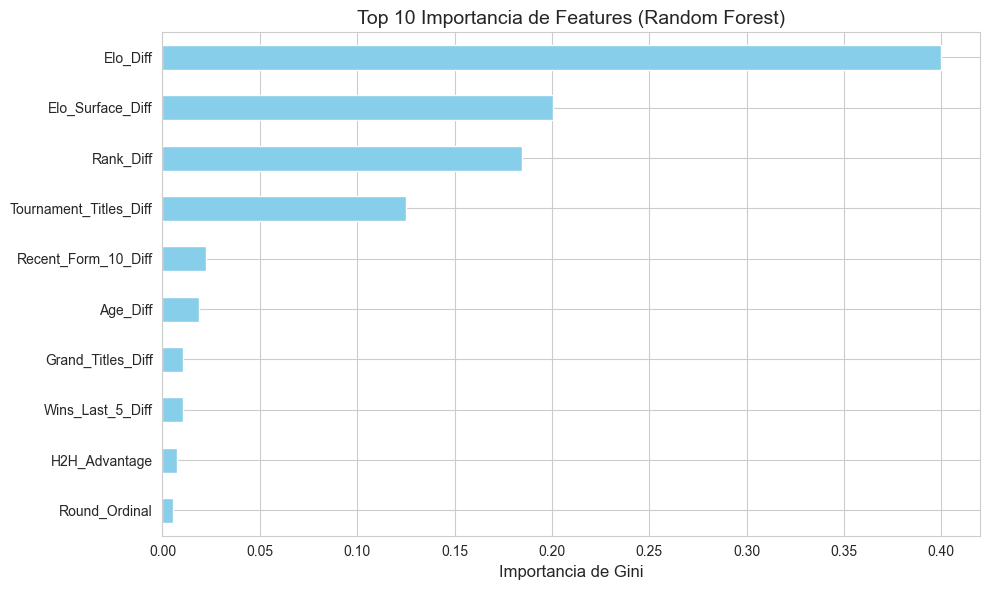

Elo_Diff                  0.399847
Elo_Surface_Diff          0.200319
Rank_Diff                 0.184533
Tournament_Titles_Diff    0.125157
Recent_Form_10_Diff       0.022248
Age_Diff                  0.018981
Grand_Titles_Diff         0.010779
Wins_Last_5_Diff          0.010410
H2H_Advantage             0.007646
Round_Ordinal             0.005384
dtype: float64


In [ ]:
# 1. Obtener el Random Forest Estimator desde el Pipeline
# La variable 'modelok' es un Pipeline, el estimador RF es el segundo paso (índice 1).
rf_estimator = modelok.steps[1][1]

# 2. Obtener la importancia de las features
feature_importances = pd.Series(
    rf_estimator.feature_importances_, 
    index=X_train.columns # Usamos las columnas de X_train para las etiquetas
)

# 3. Visualizar las Top 10 Features
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).sort_values(ascending=True).plot(
    kind='barh', 
    color='skyblue'
)
plt.title('Top 10 Importancia de Features (Random Forest)', fontsize=14)
plt.xlabel('Importancia de Gini', fontsize=12)
plt.tight_layout()
plt.show()

print(feature_importances.nlargest(10))

In [119]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelofinal = 'random_forest_modelofinal.joblib'

# Guardar el modelo
joblib.dump(modelok, modelofinal)

print(f"Modelo guardado exitosamente como: {modelofinal}")

Modelo guardado exitosamente como: random_forest_modelofinal.joblib


# MODELOS (prueba rápida)

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB # Un clasificador Naive Bayes básico

import numpy as np
import pandas as pd

def model_test_classification(X, y):
    # Modelos de Clasificación
    # Se recomienda aumentar el 'max_iter' para Regresión Logística
    # para asegurar la convergencia, especialmente en datasets grandes.
    lr = LogisticRegression(max_iter=500, random_state=42) 
    dt = DecisionTreeClassifier(random_state=42)
    rf = RandomForestClassifier(random_state=42)
    gnb = GaussianNB()

    models = [
        lr, dt, rf, gnb,
    ]

    model_names = [
        "Logistic Regression", "Decision Tree Classifier", 
        "Random Forest Classifier", "Gaussian Naive Bayes",
    ]

    # Listas para almacenar métricas de rendimiento para clasificación
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train = df[df['Date'].dt.year < 2016][FEATURE_COLUMNS]
    y_train = df[df['Date'].dt.year < 2016]['Target']
    
    X_test = df[df['Date'].dt.year >= 2016][FEATURE_COLUMNS]
    y_test = df[df['Date'].dt.year >= 2016]['Target']


    for model in models:
        model.fit(X_train, y_train)  # Entrenar el modelo
        predictions = model.predict(X_test)  # Realizar predicciones

        # Cálculo de métricas
        # Para problemas binarios, se usa 'binary', pero 'weighted' es más robusto para
        # problemas multiclase o binarios con desequilibrio de clases.
        average_type = 'weighted' 
        
        accuracy_scores.append(np.round(accuracy_score(y_test, predictions) * 100, 2))
        precision_scores.append(np.round(precision_score(y_test, predictions, average=average_type) * 100, 2))
        recall_scores.append(np.round(recall_score(y_test, predictions, average=average_type) * 100, 2))
        f1_scores.append(np.round(f1_score(y_test, predictions, average=average_type) * 100, 2))

    # Combinar los resultados en un DataFrame
    results = {
        "Model": model_names, 
        "Accuracy (%)": accuracy_scores, 
        "Precision (%)": precision_scores, 
        "Recall (%)": recall_scores,
        "F1 Score (%)": f1_scores,
    }
    results = pd.DataFrame(results)
    # Se ordena por Accuracy, que es una métrica común de alto nivel
    results = results.sort_values(by="Accuracy (%)", ascending=False) 

    return results

# Ejemplo de uso (Datos de ejemplo con 3 features y 2 clases)
# np.random.seed(42)
# X_data = np.random.rand(100, 3)
# Y_data = np.random.randint(0, 2, 100) # Clases 0 o 1
# df_results = model_test_classification(X_data, Y_data)
# print(df_results)

In [107]:
df_results = model_test_classification(X, y)
print(df_results)

                      Model  Accuracy (%)  Precision (%)  Recall (%)  \
0       Logistic Regression         65.66          65.66       65.66   
3      Gaussian Naive Bayes         65.16          65.16       65.16   
2  Random Forest Classifier         64.87          64.87       64.87   
1  Decision Tree Classifier         57.67          57.67       57.67   

   F1 Score (%)  
0         65.66  
3         65.15  
2         64.86  
1         57.66  


# CONCLUSIONES

MODELO 1  
Precisión en el set de ENTRENAMIENTO (Train): 0.7113  
Precisión del Random Forest en partidos de 2022 (test): 0.6541  
ROC AUC Score (TEST): 0.7216  

MODELO 2  
Precisión en el set de ENTRENAMIENTO (Train): 0.7217  
Precisión del Random Forest (test): 0.6572  
ROC AUC Score (TEST): 0.7232  

MODELO 3  
Precisión en el set de ENTRENAMIENTO (Train): 0.7158  
Precisión del Random Forest (test): 0.6577  
ROC AUC Score (TEST): 0.7240  

MODELO 4  
Precisión en el set de ENTRENAMIENTO (Train): 0.6965  
Precisión del Random Forest (test): 0.6518  
ROC AUC Score (TEST): 0.7126  

MODELO 5  
Precisión en el set de ENTRENAMIENTO (Train): 0.7451  
Precisión del Random Forest (test): 0.6528  
ROC AUC Score (TEST): 0.7106  

# MODELO FINAL OK

In [135]:
df.columns

Index(['index', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'Player_1', 'Player_2', 'Winner', 'Rank_1', 'Rank_2',
       'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Score', 'Age_Player1',
       'Age_Player2', 'Rank_Diff', 'Target', 'Series_Ordinal', 'Round_Ordinal',
       'Surface_Carpet', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard',
       'Court_Indoor', 'Best_of_5', 'Age_Diff', 'P1_Wins_Last_5',
       'P2_Wins_Last_5', 'Wins_Last_5_Diff', 'H2H_Advantage',
       'P1_Recent_Win_Pct', 'P2_Recent_Win_Pct', 'Recent_Form_10_Diff',
       'P1_Elo_Before', 'P2_Elo_Before', 'Elo_Diff', 'P1_Elo_Surface',
       'P2_Elo_Surface', 'Elo_Surface_Diff', 'Title_Win', 'P1_Title_Won',
       'P2_Title_Won', 'P1_Tournament_Titles_Dynamic',
       'P2_Tournament_Titles_Dynamic', 'Tournament_Titles_Diff_Dynamic',
       'Grand_Title_Win', 'P1_Grand_Title_Won', 'P2_Grand_Title_Won',
       'P1_Grand_Titles_Dynamic', 'P2_Grand_Titles_Dynamic',
       'Grand_Titles_Diff_

In [136]:
# 1. Definición de la lista de features a MANTENER (Simplificación)
# Nota: Debes replicar esta lista en tu código.
FINAL_FEATURES = [
    'Elo_Diff',
    'Elo_Surface_Diff',
    'H2H_Advantage',
    'Recent_Form_10_Diff',
    'Age_Diff',
    'Tournament_Titles_Diff_Dynamic', #nueva
    'Grand_Titles_Diff_Dynamic', #nueva
    'Round_Ordinal',
    'Series_Ordinal',
    'Court_Indoor',
    'Best_of_5',
    'Surface_Clay',
    'Surface_Grass',
    'Surface_Hard',
    # Eliminamos Rank_Diff y Pts_Diff
]

# --- 5. DEFINICIÓN FINAL DE MATRIZ DE FEATURES Y ENTRENAMIENTO ---

# Matriz de Features (X)
X = df[FINAL_FEATURES]
y = df['Target']

# 2. Re-entrenar el modelo con los parámetros óptimos del Grid Search
# Necesitarás tus variables X_train_SIMPLIFIED y y_train.

# 3. Evaluar de nuevo las métricas en X_test_SIMPLIFIED.

In [138]:
# División CRONOLÓGICA (Entrenar en el pasado, probar en el futuro)
X_train_SIMPLIFIED = df[df['Date'].dt.year < 2016][FINAL_FEATURES]
y_train = df[df['Date'].dt.year < 2016]['Target']

X_test_SIMPLIFIED = df[df['Date'].dt.year >= 2016][FINAL_FEATURES]
y_test = df[df['Date'].dt.year >= 2016]['Target']

In [139]:
# Crear el Pipeline (escalador + modelo RF)
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Grid de Hiperparámetros
param_grid = {
    'model__n_estimators': [100, 250, 400],
    'model__max_depth': [8, 12, 16, 20],
    'model__min_samples_split': [5, 10],
    'model__max_features': ['sqrt', 0.5, 0.7],
}

# -----------------------------------------------------------
# 3. Ejecución del Grid Search
# -----------------------------------------------------------

# Definir GridSearchCV
# Usamos 'roc_auc' como métrica para encontrar el mejor modelo.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,  # 3-Fold Cross-Validation (suficiente para Time Series Split)
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

# El Grid Search debe ejecutarse SÓLO sobre el conjunto de entrenamiento.
# Asegúrate de usar las variables X_train y y_train de tu división temporal.
grid_search.fit(X_train_SIMPLIFIED, y_train)

# -----------------------------------------------------------
# 4. Resultados (Post-ejecución)
# -----------------------------------------------------------

print(f"Mejor ROC AUC: {grid_search.best_score_:.4f}")
print(f"Mejores Parámetros: {grid_search.best_params_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mejor ROC AUC: 0.7370
Mejores Parámetros: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 400}


In [140]:
# Guardar el mejor modelo encontrado
modelok1 = grid_search.best_estimator_

In [141]:
y_pred = modelok1.predict(X_test_SIMPLIFIED)
accuracy = accuracy_score(y_test, y_pred)

Y_pred_train = modelok1.predict(X_train_SIMPLIFIED)
accuracy_train = accuracy_score(y_train, Y_pred_train)

print("\n--- RESUMEN FINAL ---")
print(f"Features predictivas (X) usadas: {len(FINAL_FEATURES)}")
print(f"Tamaño del set de entrenamiento: {len(X_train)} partidos")
print(f"Precisión en el set de ENTRENAMIENTO (Train): {accuracy_train:.4f}")
print(f"Precisión del Random Forest (test): {accuracy:.4f}")


--- RESUMEN FINAL ---
Features predictivas (X) usadas: 14
Tamaño del set de entrenamiento: 40250 partidos
Precisión en el set de ENTRENAMIENTO (Train): 0.6867
Precisión del Random Forest (test): 0.6527


In [142]:
# 1. Obtener las predicciones discretas y las probabilidades
y_proba = modelok1.predict_proba(X_test_SIMPLIFIED)[:, 1] # Probabilidad de que P1 gane (Clase 1)

# --- MATRIZ DE CONFUSIÓN ---
print("\n--- MATRIZ DE CONFUSIÓN (TEST) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- CLASSIFICATION REPORT (Precision, Recall, F1) ---
print("\n--- CLASSIFICATION REPORT (TEST) ---")
# La clase '1' es P1 Gana, la clase '0' es P2 Gana (P1 Pierde)
print(classification_report(y_test, y_pred))

# --- ROC AUC SCORE ---
# Mide la habilidad del modelo para distinguir entre clases
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score (TEST): {roc_auc:.4f}")


--- MATRIZ DE CONFUSIÓN (TEST) ---
[[7200 3837]
 [3832 7210]]

--- CLASSIFICATION REPORT (TEST) ---
              precision    recall  f1-score   support

           0       0.65      0.65      0.65     11037
           1       0.65      0.65      0.65     11042

    accuracy                           0.65     22079
   macro avg       0.65      0.65      0.65     22079
weighted avg       0.65      0.65      0.65     22079


ROC AUC Score (TEST): 0.7158


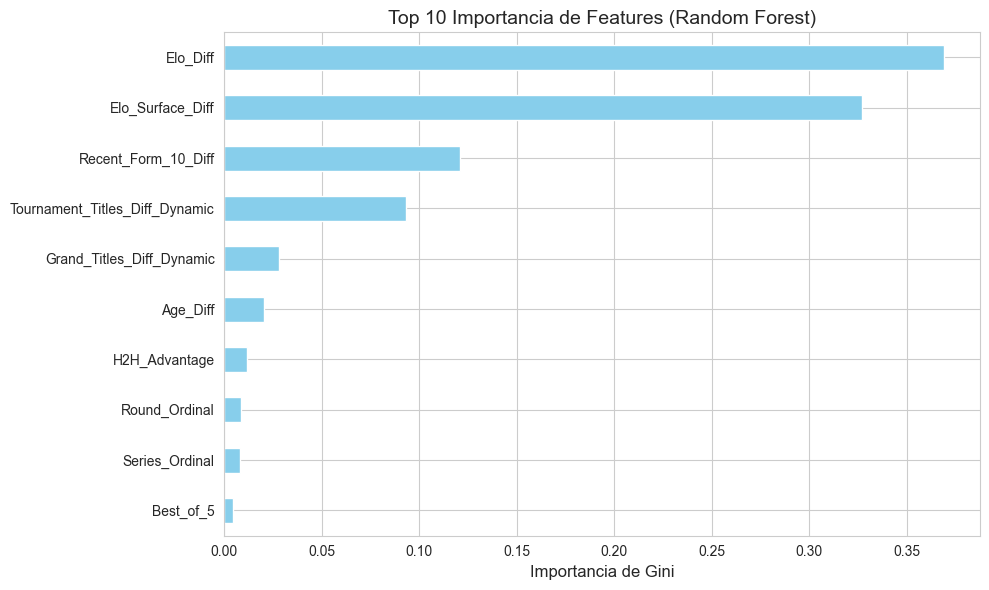

Elo_Diff                          0.369170
Elo_Surface_Diff                  0.327289
Recent_Form_10_Diff               0.120920
Tournament_Titles_Diff_Dynamic    0.093044
Grand_Titles_Diff_Dynamic         0.027897
Age_Diff                          0.020501
H2H_Advantage                     0.011472
Round_Ordinal                     0.008363
Series_Ordinal                    0.007840
Best_of_5                         0.004428
dtype: float64


In [143]:
# 1. Obtener el Random Forest Estimator desde el Pipeline
# La variable 'modelok' es un Pipeline, el estimador RF es el segundo paso (índice 1).
rf_estimator = modelok1.steps[1][1]

# 2. Obtener la importancia de las features
feature_importances = pd.Series(
    rf_estimator.feature_importances_, 
    index=X_train_SIMPLIFIED.columns # Usamos las columnas de X_train para las etiquetas
)

# 3. Visualizar las Top 10 Features
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).sort_values(ascending=True).plot(
    kind='barh', 
    color='skyblue'
)
plt.title('Top 10 Importancia de Features (Random Forest)', fontsize=14)
plt.xlabel('Importancia de Gini', fontsize=12)
plt.tight_layout()
plt.show()

print(feature_importances.nlargest(10))

In [144]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelofinalOK = 'random_forest_modelofinalOK.joblib'

# Guardar el modelo
joblib.dump(modelok1, modelofinalOK)

print(f"Modelo guardado exitosamente como: {modelofinalOK}")

Modelo guardado exitosamente como: random_forest_modelofinalOK.joblib
